<img src="NYUDB-01.png">

# THE TRAGEDY OF THE PREQUELS
## Does bandwagoning in the Star Wars community <em> plague </em> Episodes I, II, and III?

### Feroz Khalidi, [*fk597@nyu.edu*](mailto:fk597@nyu.edu)


## A long time ago, in a galaxy not so far away...

...George Lucas created the epic space movie series called ***Star Wars***. Today there exists some agreement that the original trilogy (Episodes IV, V, and VI) were better than the prequels (Episodes I, II, and III). Fans deride the newer films' plots and redditors create memes out of their dialogue (see [r/prequelmemes](www.reddit.com/r/prequelmemes)). However, this project was inspired in part by an ex-girlfriend who after watching the entire Star Wars said she loved the character Jar Jar Binks, a token for many others of all that is wrong with the prequels (I should have known then that the relationship wouldn't last. We clearly had irreconcilable differences).

But were the newer movies actually that much worse than those of the original trilogy? As a child, I loved the prequels; I grew up on them and became enthralled with their worlds. At some point though, I became wholly convinced that they were awful films. The characters seemed flat and fake and forced into roles they should have never filled. The wellspring of fantasy the CGI once provided dried up. *I freaking hated Jar Jar Binks.*

I never thought poorly of them when I first saw them. Honestly, I probably hadn't begun to dislike them until a friend had mentioned disliking them to me. Maybe I was just a four-year-old being four years old, but at the time pod racing seemed like the most exciting sport ever. Darth Maul and Jango Fett were also the coolest.

Public opinion tends to be shaped by elite cues, by individuals' relying heavily on the opinions of experts in order to form their own. The same soundbites can be parroted repeatedly. The feelings of others quickly become our own genuine sentiments. For my final project in the NYU Stern Data BootCamp course, I examined whether there might be a bandwagon effect within the Star Wars community. Additionally, I was interested in exploring some of the ways the prequels differed from the original trilogy in a quantifiably measurable way. Obviously there is much to a movie that cannot be analyzed from the data alone. Factors such as the actors' performances and the quality of special effects, for example, are highly subjective and qualitative. However, people's opinions and reactions to them can be measured and quantified. This also makes any significant differences that can arise solely on the basis of a movie's script and prescribed dialogue that much more interesting to explore. 

First, I look at survey data gathered on individuals' attitudes towards the different Star Wars movies and main characters. Next, I use the Star Wars helper API to examine which characters are in which movies. From there, I decided to get the script for each film and do some basic analysis of who's speaking in which movies. Lastly, just for fun, I conduct some basic natural language processing of the dialogue to tease out any patterns hidden in them. 



##### "If many believe so, it is so"

## INITIALIZATION

First, let's load the libraries necessary. I'll need to be able to look at data frames and perform some basic mathematical and statistical manipulations. I will then need packages to generate graphics that can represent them well. Additional libraries are also needed to access the Star Wars API, to scrape and process the movie scripts, and to process the natural language contained within them.

Note: I keep all the data sources linked directly and do all the data manipulation in the script such that someone could open up this notebook and run it. At times, it makes the notebook a bit cluttered, especially when parsing the scripts, but I think the benefits gained from reproducibility far outweigh the excess code.


In [1]:
import pandas as pd
import numpy as np 
import math
from collections import Counter

import matplotlib.pyplot as plt 
import plotly 
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go 

import swapi as sw

import requests  
from bs4 import BeautifulSoup
import re

import nltk
import string
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline   
plotly.offline.init_notebook_mode(connected=True)

## PART A
### Gathering and Preparing the Survey Data

The first dataset I look at comes from a FiveThirtyEight poll that the site had run through Survey Monkey Audience, surveying 1,186 respondents from June 3 to 6, 2014 (the data is available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/star-wars-survey)). Seventy-nine percent (*n*=835) of those respondents said they had watched at least one of the “Star Wars” films. I am accessing it directly through the 538 Github repository and reading the csv with pandas. After cleaning and parsing the data, I will look at the participants' ratings of the different films and characters.



In [2]:
URL = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/star-wars-survey/StarWars.csv' #data location
    
star_wars = pd.read_csv(URL, encoding="ISO-8859-1")#accessing it

star_wars.iloc[0:10, 9:] #retitle columns
for index in range(3,9):
    star_wars.rename(
        columns={star_wars.columns[index]:'Seen: ' + star_wars.iloc[0,index][11:]},
        inplace=True
    )
for index in range(9,15):
    star_wars.rename(
        columns={star_wars.columns[index]:'Ranking: ' + star_wars.iloc[0,index][11:]},
        inplace=True
    )    
for index in range(15,29):
    star_wars.rename(
        columns={star_wars.columns[index]:'Popularity: ' + star_wars.iloc[0,index]},
        inplace=True
    )
    
#recode as booleans and set index

star_wars.rename(columns={star_wars.columns[31]:'Do you consider yourself to be a fan of the Expanded Universe?'}, inplace=True)
    
star_wars.drop(0, inplace=True)

star_wars.set_index('RespondentID', inplace=True)

yes_no = {
   'Yes': True,
   'No': False 
}

star_wars.iloc[:,0] = star_wars.iloc[:,0].map(yes_no)
star_wars.iloc[:,1] = star_wars.iloc[:,1].map(yes_no)
star_wars.iloc[:,30] = star_wars.iloc[:,30].map(yes_no)

for index in range(2,8):
    col_name = star_wars.columns[index]
    star_wars[col_name] = pd.notnull(star_wars[col_name])
    
star_wars[star_wars.columns[8:14]] = star_wars[star_wars.columns[8:14]].astype(float)

string_to_number = { #recode popularity data
    'Very favorably' : 2,
    'Somewhat favorably' : 1,
    'Neither favorably nor unfavorably (neutral)' : 0,
    'Somewhat unfavorably' : -1,
    'Very unfavorably' : -2,
    'Unfamiliar (N/A)' : None,
    None : None
}
no_nan = star_wars[star_wars.columns[14:28]].fillna('Unfamiliar (N/A)')
star_wars[star_wars.columns[14:28]] = no_nan.applymap(lambda x: string_to_number[x])
star_wars.index = range(len(star_wars))

star_wars.head() #preview the data

,Have you seen any of the 6 films in the Star Wars franchise?,Do you consider yourself to be a fan of the Star Wars film franchise?,Seen: Episode I The Phantom Menace,Seen: Episode II Attack of the Clones,Seen: Episode III Revenge of the Sith,Seen: Episode IV A New Hope,Seen: Episode V The Empire Strikes Back,Seen: Episode VI Return of the Jedi,Ranking: Episode I The Phantom Menace,Ranking: Episode II Attack of the Clones,...,Popularity: Yoda,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
0,True,True,True,True,True,True,True,True,3.0,2.0,...,2.0,I don't understand this question,Yes,False,No,Male,18-29,NaN,High school degree,South Atlantic
1,False,NaN,False,False,False,False,False,False,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,Male,18-29,"$0 - $24,999",Bachelor degree,West South Central
2,True,False,True,True,True,False,False,False,1.0,2.0,...,NaN,I don't understand this question,No,NaN,No,Male,18-29,"$0 - $24,999",High school degree,West North Central
3,True,True,True,True,True,True,True,True,5.0,6.0,...,2.0,I don't understand this question,No,NaN,Yes,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West North Central
4,True,True,True,True,True,True,True,True,5.0,4.0,...,1.0,Greedo,Yes,False,No,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West North Central


## PART B
### Plotting the Overall Rankings
Now we want to look at people's rankings of each movie. This is taken from each participant's ranking the six movies from first to sixth such that the closer to 1 a rating is, the better.

In [3]:
ranking = star_wars.iloc[:,8:14] #splice the ranking data into a seperate variable
ranking_means = ranking.apply(np.mean) #calculate and store the means
ranking_sem = ranking.apply(np.std) / np.sqrt(len(ranking)) #calculate and store the std errors

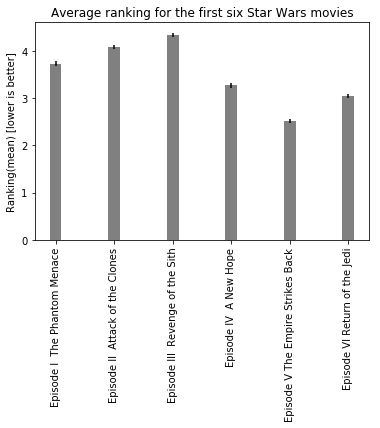

In [4]:
width = 0.2 #width of the bars
index = np.arange(len(ranking_means)) #index for x_locations of bars

fig, ax = plt.subplots() 
rects = ax.bar(index, ranking_means, width, color='grey', yerr=ranking_sem)
ax.set_ylabel('Ranking(mean) [lower is better]')
ax.set_title('Average ranking for the first six Star Wars movies')
ax.set_xticks(index)
ax.set_xticklabels([(x[9:]) for x in ranking.columns], rotation='vertical');

Error bars represent the standard errors of the mean. The graph is a not very intuitive because higher bars represent lower rankings, but we can see that the original trilogy is ranked more highly among the six films on average than are the prequels. It's also does not look very nice. Here we'll replot it using the interactive plotly library.

In [5]:
numerals = ['I', 'II', 'III', 'IV', 'V', 'VI']
xdata = ['Ep ' + x for x in numerals] #create abreviations for x

trace1 = go.Bar(  #Generating the bars
    hoverinfo = 'text',
    x = xdata,
     textfont=dict(
        family='sans serif',
        size=18,
        color='#1f77b4'
    ),
    y = [6 - x for x in ranking_means], #recoding such that shorter is worse, taller better
    text = [str(ranking_means[x]) + '<br>Average Film Ranking (out of 6)<br>' + list(ranking.columns)[x][9:] for x in range(6)], #hover captions]
      marker=dict(
        color='rgb(252,223,0)'),
    opacity=1,
    width=.6,
)

data = [trace1]
layout = go.Layout( #making it look and function well
    title='<b>Original Trilogy Reigns Supreme</b> <br> Average Films Rankings',
    titlefont =dict(color='rgb(255,255,255)', 
                   size =21,
                   family = 'open sans'),          
    plot_bgcolor='rgba(10, 0, 0, 1)',
    paper_bgcolor ='rgba(10, 0, 0, 1)',
    height=600, 
    annotations=[ ],
    xaxis=dict(tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor='rgb(255,255,255)', linewidth=1)
,
    yaxis=dict(range = [0, 5], tickvals = [0,.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5],tickmode="array", ticktext = [6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1], tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor ='rgb(0,0,0)', linewidth=0),
   
)

fig = go.Figure(data=data, layout=layout) #now let's plot it
iplot(fig)
    

Much better. The prequels are clearly ranked lower among the six films than are the original films. But we need to explore the data further for a couple of reasons. First, this includes people who have not seen all six films, and so it might be better to exclude them because they cannot give a fair assessment. Second, this includes everyone, fans and non-fans. Obviously if you have seen all six star wars films you are more likely to be a fan than if you haven't, but there are still some people, like my Gungan loving ex, who have seen all six films but are not themselves fans.

## PART C
### Looking for Film-Fanking Differences between Fans and Non-Fans

In [6]:
seen_all = star_wars[(star_wars['Seen: Episode I  The Phantom Menace'] == True) & #store seperately data for only individuals who have seen all the movies
                     (star_wars['Seen: Episode II  Attack of the Clones'] == True) &
                     (star_wars['Seen: Episode III  Revenge of the Sith'] == True) &
                     (star_wars['Seen: Episode IV  A New Hope'] == True) &
                     (star_wars['Seen: Episode V The Empire Strikes Back'] == True) &
                     (star_wars['Seen: Episode V The Empire Strikes Back'] == True)]
 
seen_all_ranking = seen_all.iloc[:,8:14] #get the rankings
seen_all_ranking_means = seen_all_ranking.apply(np.mean) #get the means

In [7]:
fan = seen_all[seen_all["Do you consider yourself to be a fan of the Star Wars film franchise?"] == True]
fan_rankings = fan.iloc[:,8:14] #get the fans' rankings

non_fan = seen_all[seen_all["Do you consider yourself to be a fan of the Star Wars film franchise?"] == False]
non_fan_rankings = non_fan.iloc[:,8:14] #get the non-fans' rankings

print('seen all:             n =', len(seen_all)) #how many have seen all the six films
print('seen all, fans:       n =', len(fan))
print('seen all, non_fans:   n =', len(non_fan))

seen all:             n = 473
seen all, fans:       n = 412
seen all, non_fans:   n = 61


In [8]:
fan_ranking_means = fan_rankings.apply(np.mean) #get the fans' means
fan_ranking_sem = fan_rankings.apply(np.std) / np.sqrt(len(fan_rankings)) #std error

non_fan_ranking_means = non_fan_rankings.apply(np.mean) #ditto for non-fans
non_fan_ranking_sem = non_fan_rankings.apply(np.std) / np.sqrt(len(non_fan_rankings))

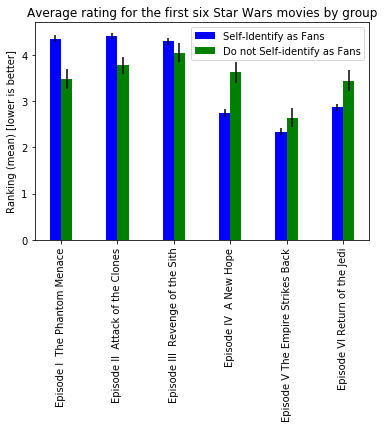

In [9]:
width = 0.2  #let's plot it all 
index = np.arange(len(ranking_means))

fig, ax = plt.subplots()
rects_fan = ax.bar(index, fan_ranking_means, width, color='blue', yerr=fan_ranking_sem)
rects_non_fan = ax.bar(index + width, non_fan_ranking_means, width, color='green', yerr=non_fan_ranking_sem)

ax.set_ylabel('Ranking (mean) [lower is better]')
ax.set_title('Average rating for the first six Star Wars movies by group')
ax.set_xticks(index + width/2)
ax.set_xticklabels([(x[9:]) for x in ranking.columns], rotation='vertical');


ax.legend((rects_fan[0], rects_non_fan[0]), ('Self-Identify as Fans', 'Do not Self-identify as Fans'));

There it is! Even though the prequels are uniformly disliked by fans and the original trilogy revered, the trend is not as strong among the non-fans. Non-fans tend to rank Episode I almost as highly on average as Episodes IV and VI.

But just as before, let's reconfigure and reconstruct the figure in plotly.


In [10]:
trace1 = go.Bar( #Fans bar
    name = 'Self-Identify as Fans',
    hoverinfo = 'text',
    x = xdata,
     textfont=dict(
        family='sans serif',
        size=18,
        color='#1f77b4'
    ),
    y = [6 - x for x in fan_ranking_means],
    text = [str(fan_ranking_means[x]) + '<br>Average Fan Film Ranking (out of 6)<br>' + list(ranking.columns)[x][9:] for x in range(6)], #
      marker=dict(
        color='fd972b'),

    opacity=1,
    width=.4,
)

trace2 = go.Bar( #Non-Fans
    name = 'Do not Self-Identify as Fans',
    hoverinfo = 'text',
    x = xdata,
     textfont=dict(
        family='sans serif',
        size=18,
        color='#1f77b4'
    ),
    y = [6 - x for x in non_fan_ranking_means], #recoding such that shorter is worse, taller better
    text = [str(non_fan_ranking_means[x]) + '<br>Average Non-Fan Film Ranking (out of 6)<br>' + list(ranking.columns)[x][9:] for x in range(6)], #hover text
      marker=dict(
        color='1a75bc'),

    opacity=1,
    width=.4,
)

data = [trace1, trace2]

layout = go.Layout( #make it look nice
    barmode='group',
    title='<b>Prequel-Hate among Fans</b> <br> Average Films Rankings by Self-Identified Fan Status',
    titlefont =dict(color='rgb(255,255,255)', 
                   size =21,
                   family = 'open sans'),          
    plot_bgcolor='rgba(10, 0, 0, 1)',
    paper_bgcolor ='rgba(10, 0, 0, 1)',
    height=700, 
    annotations=[ ],
    xaxis=dict(tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor='rgb(255,255,255)', linewidth=1)
,
    yaxis=dict(range = [0, 5], tickvals = [0,.5,1,1.5,2,2.5,3,3.5,4, 4.5, 5],tickmode="array", ticktext = [6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1], tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor ='rgb(0,0,0)', linewidth=0), #making the ticks match the inverted values to preserve proportionality
    legend=dict(orientation = 'h',font=dict(color='rgb(255,255,255)')),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig) #plot it



    

The above figure clearly shows that those surveyed who identified as fans ranked the prequels much lower relative to the non-fans. This suggests that there may be a bandwagon effect within the Star Wars community in which, as a member, it seems canon to love the original trilogy and sacrilege to like the prequels. One of the benefits of the Survey Monkey Audience is that there is probably less self-selection bias than through other advertised Star Wars related polls. Less than half of the participants had seen all six films and nearly a quarter had seen none. This strengthens the external validity of the data to the overall population. But at least everyone still hates Jar-Jar though, right?

## Part D
### Evaluating Character Popularity between Fans and Non-Fans

This was an idea that has been sitting with me for a while. When did I start hating Jar Jar? Why did I find it so appalling that someone whose opinion I otherwise valued was so clearly wrong about something so clearly awful?

Jar Jar Binks is possibly one of the most hated characters in a film series of all time. Despite his ostensibly loveable goofiness and being both caring and loyal, Jar Jar is almost universally despised. He is easy to hate. For many Star Wars fans, he represents everything that George Lucas did to ruin the series. He is a computer generated mess of nonsensical dialogue and concocted idiocy that at the same time forces the plot and is completely unnecessary to the story. But to someone initially unfamiliar with the series and also to my younger self, he wasn't that bad. *I think I might have even liked him...*

To evaluate the possibly insidious effects of bandwagoning on individuals' views of the characters, I am again taking the data from only participants who had seen all 6 films and splitting it along fans and non-fans. From there I will plot the results.



In [13]:
seen_all_JJB = seen_all.iloc[:,14:28] #get character popularities from seen_all data
seen_all_JJB_means = seen_all_JJB.apply(np.mean) #means
seen_all_JJB_sem = seen_all_JJB.apply(np.std) / np.sqrt(len(seen_all_JJB)) #std err

fan_JJB = fan.iloc[:,14:28] #now for fans
fan_JJB_means = fan_JJB.apply(np.mean)
fan_JJB_sem = fan_JJB.apply(np.std) / np.sqrt(len(fan_JJB))

non_fan_JJB = non_fan.iloc[:,14:28] #ditto for non-fans
non_fan_JJB_means = non_fan_JJB.apply(np.mean)
non_fan_JJB_sem = non_fan_JJB.apply(np.std) / np.sqrt(len(non_fan_JJB))

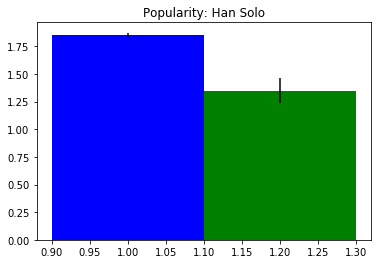

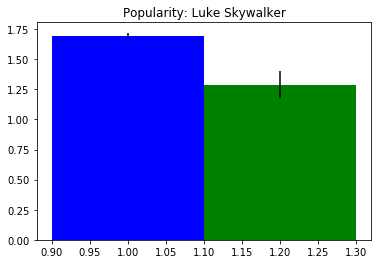

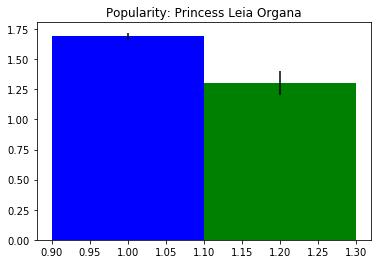

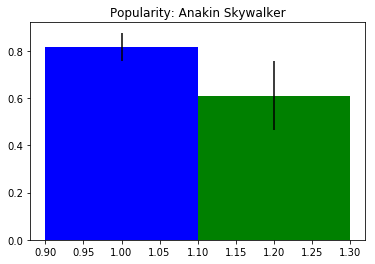

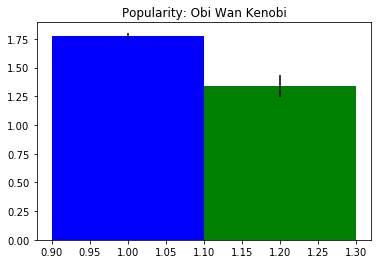

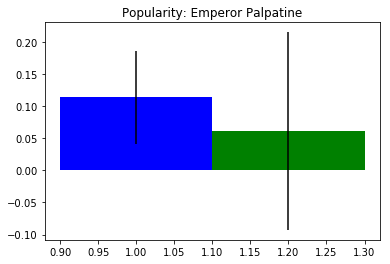

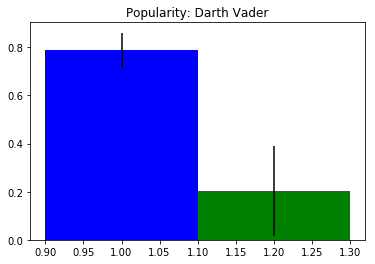

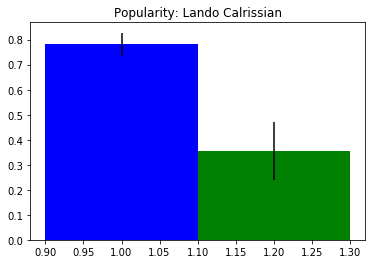

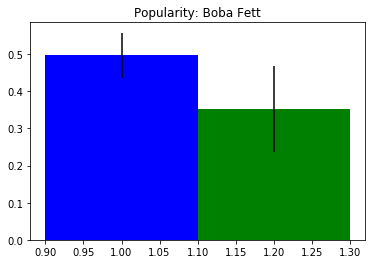

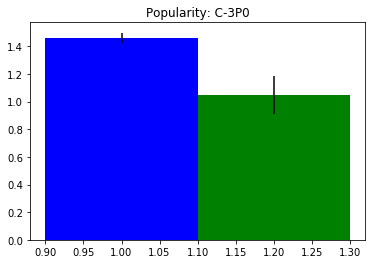

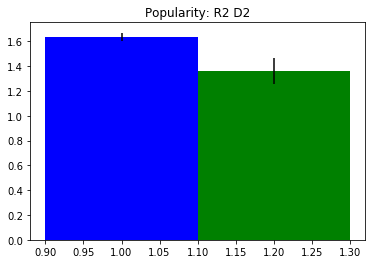

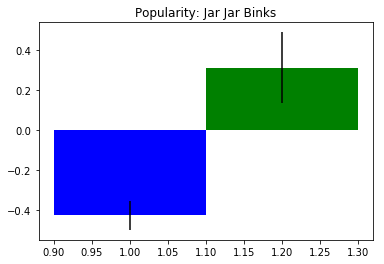

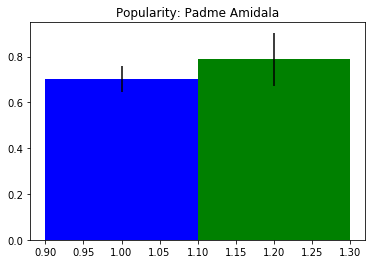

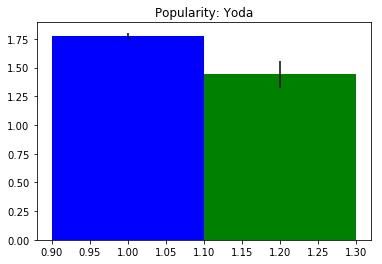

In [14]:
for character in seen_all_JJB.columns: #plot each character's popularity among fans and non-fans using a for loop
   
    fig, ax = plt.subplots()
    index = 1
    width = 0.2
    rects_fan_JJB = ax.bar(index, fan_JJB_means[character], width, color='blue', yerr=fan_JJB_sem[character])
    rects_non_fan_JJB = ax.bar(index + width, non_fan_JJB_means[character], width, color='green', yerr=non_fan_JJB_sem[character])
    ax.set_title(character);

First, one can see a significant difference between the fans and non-fans with regards to their favorability of Jar Jar Binks. While non-fans don't mind or even like the oafish Gungan, fans actively dislike him. Second, aside from Jar Jar and also Padme, there is an almost constantly higher favorability among fans. This makes sense, as fans of a series are more likely to find its characters favorable than someone who had seen all six films and still does not consider themselves a fan. Interestingly, Padme is also ranked higher by non-fans than by fans. Padme, along with Jar Jar, appears exclusively in the prequels. Anakin also appears predominantly in the prequels, but because Darth Vader is Anakin Skywalker [SPOILER ALERT! I'm sorry], it is likely that the two are more or less imagined to be the same character. This is further supported by the almost equal rankings that fall within each other's standard error bars. This trend, however, is not seen among non-fans.

I am interested in exploring this relationship between characters and their appearances in which trilogies further. But before that, let's create a nicer figure with plotly.

In [15]:
trace1 = go.Bar(
    name = 'Self-Identify as Fans',
    hoverinfo = 'text',
    x = [character[12:] for character in list(seen_all_JJB.columns)],
     textfont=dict(
        family='sans serif',
        size=18,
        color='#1f77b4'
    ),
    y = fan_JJB_means,
    text = [str(fan_JJB_means[x]) + '<br>Average Fan Character Rating<br>' + seen_all_JJB.columns[x][12:] for x in range(len(seen_all_JJB.columns))], #
      marker=dict(
        color='fd972b'),

    opacity=1,
    width=.4,
)

trace2 = go.Bar(
    name = 'Do not Self-Identify as Fans',
    hoverinfo = 'text',
    x = [character[12:] for character in list(seen_all_JJB.columns)],
     textfont=dict(
        family='sans serif',
        size=18,
        color='#1f77b4'
    ),
    y = non_fan_JJB_means,
    text = [str(non_fan_JJB_means[x]) + '<br>Average Non-Fan Character Rating<br>' + seen_all_JJB.columns[x][12:] for x in range(len(seen_all_JJB.columns))],
      marker=dict(
        color='1a75bc'),

    opacity=1,
    width=.4,
)

data = [trace1, trace2]

layout = go.Layout(
    barmode='group',
    title='<b>The Jar Jar Effect</b> <br> Average Character Ratings by Self-Identified Fan Status',
    titlefont =dict(color='rgb(255,255,255)', 
                   size =21,
                   family = 'open sans'),          
    plot_bgcolor='rgba(10, 0, 0, 1)',
    paper_bgcolor ='rgba(10, 0, 0, 1)',
    height=700, 
    annotations=[ ],
    xaxis=dict(anchor='free',position=0.22,tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor='rgb(0,0,0)', linewidth=0)
,
    yaxis=dict(tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor ='rgb(0,0,0)', linewidth=0),
    legend=dict(orientation = 'h',font=dict(color='rgb(255,255,255)'), y = 0),
    margin=dict(t = 100),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)



    

## PART E
### Creating a Venn Diagram of Characters Appearing in Each Trilogy

The Star Wars API is the world's first quantified and programmatically-formatted set of Star Wars data.
They've watched and re-watched each Star Wars film, collecting and formatting this data in JSON with its own Python helper library. [For more info, please see their documentation.](https://swapi.co/documentation)

Here we use swapi to get the characters in each movie and create a responsive venn diagram with the information.

In [16]:
x = {sw.get_film(movie): sw.get_film(movie).get_characters().items for movie in range(1,7)} #get all the character items for each film

In [17]:
d = [] #need to recode movies 0 = 4, 1=5,2=6, 3=1, 4=2, 5=3
for movie in range(len(list(x.values()))): #this for loop creates the structure for a data frame that will contain the info
    for person in list(x.values())[movie]:
        d.append({'Person': str(person)[10:].rstrip('>'), 'Movie': (movie+4) if movie<3 else (movie-2)})
df = pd.DataFrame(d)#.set_index(['Person'])
df = df.groupby('Person')['Movie'].apply(list).reset_index()      
df.set_value(8, 'Person', 'Beru Lars')
df['VD Category'] = "" #VD = Venn Diagram

In [18]:
#parse through it, sorting whether it's a prequel or sequel 
preq_only = [] #initialize a bunch of variables for the following loop
both = []
ot_only = []
preq_only_count = 0
both_count = 0
ot_only_count = 0
preq_lbls = []
ot_lbls = []
both_lbls = []

for index, row in df.iterrows():
    if (any(i in [1,2,3]  for i in row[1])) and (not any(i in [4,5,6]  for i in row[1])): #if in prequels but not ot
        row[2] = "Prequels" #categorizes it in df
        preq_only.append(row[0]) #adds name to list of characters in prequels only
        preq_only_count += 1 #adds to a counter (len of the above variable could have worked to but it's nice to have the int as its own variable)
        preq_lbls.append(row[1])  #store which movies theyre in for hovertext
    elif (not any(i in [1,2,3]  for i in row[1])) and (any(i in [4,5,6]  for i in row[1])): #if ot but not prequels
        row[2] = "Original Trilogy"
        ot_only.append(row[0])
        ot_only_count += 1
        ot_lbls.append(row[1])
    elif (any(i in [1,2,3]  for i in row[1])) and (any(i in [4,5,6]  for i in row[1])): #if in both, (an 'else' may have sufficed but I always prefer to specify conditions where I have one in mind)
        row[2] = "Both"
        both.append(row[0])
        both_count += 1
        both_lbls.append(row[1])
df.head(10) #preview it

,Person,Movie,VD Category
0,Ackbar,[6],Original Trilogy
1,Adi Gallia,"[1, 3]",Prequels
2,Anakin Skywalker,"[1, 2, 3]",Prequels
3,Arvel Crynyd,[6],Original Trilogy
4,Ayla Secura,"[1, 2, 3]",Prequels
5,Bail Prestor Organa,"[2, 3]",Prequels
6,Barriss Offee,[2],Prequels
7,Ben Quadinaros,[1],Prequels
8,Beru Lars,"[4, 2, 3]",Both
9,Bib Fortuna,[6],Original Trilogy


Now that it's been initially parsed, let's combine them in an order such that they can go into the venn diagram

In [19]:
#note: coordinates are hard coded, but changing the height and width of the layout resizes proportionally, effectively achieving the same result
ot_x= [2.42 for x in range(ot_only_count)]  #x coordinates for left VD 
ot_y=np.linspace(1.9,.1, ot_only_count) #y coordinates for left vd
preq_x = [.74 for x in range(math.ceil((preq_only_count / 2)))] + [1.14 for x in range(math.floor((preq_only_count / 2)))]
preq_y=np.concatenate((np.linspace(1.9,.1, math.ceil((preq_only_count / 2))),np.linspace(1.9,.1, math.floor((preq_only_count / 2)))))
both_x = [1.68 for x in range(both_count)]
both_y = (np.linspace(1.6,.4, both_count))
all_x = ot_x + preq_x + both_x
all_y = np.concatenate((ot_y, preq_y, both_y))
all_text = ot_only+preq_only+both
lbls = ot_lbls + preq_lbls + both_lbls

labels=['' for x in all_text] #generate hover text
for i in range(len(all_text)):
    lbl = ''
    for movie in lbls[i]:
        lbl += numerals[movie-1] + ' '
    labels[i] = all_text[i] + '<br>Movies: ' + lbl.rstrip()
    
annotations = []

for i in range(len(all_text)):#generate the words to be plotted on the VD
    annotations.append(dict(x=all_x[i], y=all_y[i], text=all_text[i],
                                  font=dict(family='Arial', size=14,
                                  color='black'),
                                  showarrow=False,))
annotations.append(dict(x=2.42, y=-.1, text='Original Trilogy Only', #label right vd
                                  font=dict(family='Arial', size=18,
                                  color='white'),
                                  showarrow=False,))
annotations.append(dict(x=1, y=-.1, text='Prequels Only', #label right vd
                                  font=dict(family='Arial', size=18,
                                  color='white'),
                                  showarrow=False,))
annotations.append(dict(x=1.68, y=.1, text='Both', #label right vd
                                  font=dict(family='Arial', size=18,
                                  color='white'),
                                  showarrow=False,))
    

In [20]:
trace0 = go.Scatter( #create the scatterplot
    x=all_x,
    y=all_y,
    text=labels,
    mode='none',
    hoverinfo = 'text',
    hoveron = 'points',
    textfont=dict(
        color='black',
        size=12,
        family='Arial',
    ),
)

data = [trace0]

layout = { #make it look good, note:this one had to be done as a dictionary manually so that the shapes attribute would function properly
    'title' :'<b>Twin Suns of Tatooine</b> <br>Charaters Appearing in the Different Trilogies',
    'titlefont' :{'color' :'rgb(255,255,255)', 
                   'size' :21,
                   'family': 'open sans'},          
    'plot_bgcolor':'rgba(10, 0, 0, 1)',
    'paper_bgcolor':'rgba(10, 0, 0, 1)',
    'hovermode': 'closest',
    'xaxis': {
        'showticklabels': False,
        'autotick': False,
        'showgrid': False,
        'zeroline': False,
    },
    'yaxis': {
        'showticklabels': False,
        'autotick': False,
        'showgrid': False,
        'zeroline': False,
    },
    'shapes': [
         {
            'opacity': 1, #create two background white circles so opacity works on black page
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'white',
            'x0': 0,
            'y0': 0,
            'x1': 2,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'white',
            },
        },
        {
            'opacity': 1, #second
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'white',
            'x0': 1.35,
            'y0': 0,
            'x1': 3.35,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'white',
            },
        },
        {
            'opacity': 0.3, #Left circle
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'green',
            'x0': 0,
            'y0': 0,
            'x1': 2,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'green',
            },
        },
       
        {
            'opacity': 0.3, #right
            'xref': 'x',
            'yref': 'y',
            'fillcolor': 'blue',
            'x0': 1.35,
            'y0': 0,
            'x1': 3.35,
            'y1': 2,
            'type': 'circle',
            'line': {
                'color': 'blue',
            },
        }
    ],
'margin': { #get the dimensions right
        'l': 20,
        'r': 20,
        'b': 100,
        't': 100
    },
    'height': 800,
    'width': 1000,
    

'annotations': annotations, #add appropriate labels
}

fig = { 
    'data': data,
    'layout': layout,
}

iplot(fig) #plot it

As this venn diagram illustrates, there are a lot of characters in the prequels. Most of the characters that appear in the original trilogy are nameless and otherwise forgettable stormtroopers and rebel fighters that did not get their own character items in swapi. Compared to the initial list from the 538 diagram, we see that Anakin, Jar Jar, and Padme appear in the prequels only, Han and Lando appear in the sequels only, and Boba, Darth Vader, Leia, Luke, Obi-Wan, Palpatine, R2, and Yoda appear in both. However, just because a character appears in one means they actually were a real presence in the film. For example, Luke and Leia appear in the prequels just as infants at the end of Episode III. One might argue that Anakin does appear in the original trilogy when Darth Vader takes off his mask [Again, Spoiler Alert!!] and when he appears as a force ghost at the end of Episode VI. So, while a binary is initially helpful, there is more information that might be contained in the dialogue directly from the movie scripts themselves.

## PART F
### Collecting and Parsing the Star Wars Scripts for Dialogue

The third set of data comes from IMSDB (The Internet Movie Script Database: "The web's largest movie script resource!"). It consists of the six scripts to the original trilogy and the prequels. They are contained in the html webpage and so need to be parsed with beautiful soup 4. Some of them have different formatting and so require novel and somewhat esoteric code in order to get at the language itself. The code itself isn't that brilliant but the pattern recognition required for some of the scripts took careful examination of the scripts in order to be automated (with a few corrections after).

In [21]:
url4 = 'http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html' #get the urls from isdb
url5 = 'http://www.imsdb.com/scripts/Star-Wars-The-Empire-Strikes-Back.html'
url6 = 'http://www.imsdb.com/scripts/Star-Wars-Return-of-the-Jedi.html'
url1 = 'http://www.imsdb.com/scripts/Star-Wars-The-Phantom-Menace.html'
url2 = 'http://www.imsdb.com/scripts/Star-Wars-Attack-of-the-Clones.html'
url3 = 'http://www.imsdb.com/scripts/Star-Wars-Revenge-of-the-Sith.html'

ep4  = requests.get(url4) #access the information contained
ep5  = requests.get(url5)
ep6  = requests.get(url6)
ep1  = requests.get(url1)
ep2  = requests.get(url2)
ep3  = requests.get(url3)

In [22]:
ep4_soup = BeautifulSoup(ep4.content, 'html.parser') #parse the html
ep5_soup = BeautifulSoup(ep5.content, 'html.parser')
ep6_soup = BeautifulSoup(ep6.content, 'html.parser')

ep1_soup = BeautifulSoup(ep1.content, 'html.parser')
ep2_soup = BeautifulSoup(ep2.content, 'html.parser')
ep3_soup = BeautifulSoup(ep3.content, 'html.parser')

In [23]:
ep4_script = ep4_soup.find_all('pre')[0] #for these five scripts, the screenplay is conatined within the <pre> tags
ep4_raw = ep4_script.get_text()

ep5_script = ep5_soup.find_all('pre')[0]
ep5_raw = ep5_script.get_text()

ep6_script = ep6_soup.find_all('pre')[0]
ep6_raw = ep6_script.get_text()

ep1_script = ep1_soup.find_all('pre')[0]
ep1_raw = ep1_script.get_text()

ep2_script = ep2_soup.find_all('pre')[0]
ep2_raw = ep2_script.get_text()


In [24]:
ep3_raw = ep3_soup.get_text() #episode 3 required finding the beginning and end manually
for m in re.finditer('STAR WARS EPISODE 3: REVENGE OF THE SITH SCRIPT', ep3_raw):
    I1 = m.start()
for m in re.finditer('END TITLES.', ep3_raw):
    I2 = m.end()   
    
ep3_raw = ep3_raw[I1:I2]


Now we have the raw scripts and can begin to access the dialogue itself. I am interested in seeing how often a character actually speaks in each movie. The basic structure I use for each script is the same but the exact characters or patterns of characters that signal the beginning of a dialogue and the current speaker vary from one to another. Hence, I modified the code for each script. There are also some typos and differences in names across different scripts (and even sometimes variations within) and so I do some looping and cleaning up a bit before and after parsing.

In [25]:
ep4_split = ep4_raw.split('\n') #split the script into lines
ep4_length = len(ep4_split) 
speaker_spaces = '                                     '#indent indicates speaker
dialogue_spaces = '                         ' #indent indicates dialogue
ind = ep4_split.index('               Another blast shakes them as they struggle along their way.') #find where dialogue begins
end = ep4_split.index('               INT. MASSASSI OUTPOST - MAIN THRONE ROOM')
j=-1 #-1 so it doesnt start copying until after the first character is done speaking
ep4_parsed = []
char = []
lines = []
while ind < end: #this is gonna go through every line, when there is a speaker it saves the speakers name and stores all their lines of dialogue until the next speaker and then begins it again
    if ep4_split[ind] == '':
        ind = ind + 1
    elif ep4_split[ind] != '':
        if ep4_split[ind][15] != ' ':
            ind = ind + 1
        elif ep4_split[ind][15] == ' ':
            if ep4_split[ind][0:37] == speaker_spaces:
                if j >= 0:
                    lines = ''.join(temp)
                    ep4_parsed.append([char, lines])
                char = ep4_split[ind][37:]
                temp = []
                j = j + 1 
                ind = ind + 1
            elif ep4_split[ind][:25] == dialogue_spaces:
                temp.append(ep4_split[ind][25:])
                ind = ind + 1
        else:
            ind = ind + 1

lines = ''.join(temp) # to make sure we get the last lines of dialogue
ep4_parsed.append([char, lines])

for line in ep4_parsed: #some cleaning up
    line[1] = line[1].replace(') ', ')')
    line[1] = line[1].replace(')', ') ')
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0][-7:] == 'S VOICE':
        line[0] = line[0][:-8]
    if line[0] == 'VADER':
        line[0] = 'DARTH VADER'
    elif line[0] == 'BEN':
        line[0] = 'OBI-WAN'

In [26]:
ep5_split = ep5_raw.split('\n')
ep5_length = len(ep5_split)  # number of lines
speaker_spaces = '\t\t\t\t'
dialogue_spaces = '\t\t'
ind = ep5_split.index('transmitter.  His Tauntaun shifts and moans nervously beneath him.') #find where dialogue begins
end = ep5_split.index('Luke wriggles his fingers, makes a fist, and relaxes it.  His hand is ') #ends
j=-1
ep5_parsed = []
char = []
lines = []       #same basic structure but with tab characters instead of spaces
while ind < end:
    if ep5_split[ind] == '':
        ind = ind + 1
    elif ep5_split[ind][0] != '':
        if ep5_split[ind][0] != '\t':
            ind = ind + 1
        elif ep5_split[ind][0] == '\t':
            if ep5_split[ind][:4] == speaker_spaces:
                if j >= 0:
                    lines = ''.join(temp)
                    ep5_parsed.append([char, lines])
                char = ep5_split[ind][4:]
                temp = []
                j = j + 1 
                ind = ind + 1
            elif ep5_split[ind][:2] == dialogue_spaces:
                temp.append(ep5_split[ind][2:])
                ind = ind + 1
        else:
            ind = ind + 1

lines = ''.join(temp) # to make sure we get the last line
ep5_parsed.append([char, lines])

for line in ep5_parsed:
    line[1] = line[1].replace(') ', ')')
    line[1] = line[1].replace(')', ') ')
    line[1] = line[1].replace('\t(','     (')
    line[1] = line[1].replace('\t ','')
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0][-7:] == 'S VOICE':
        line[0] = line[0][:-8]
    if line[0] == 'VADER':
        line[0] = 'DARTH VADER'
    elif line[0] == 'BEN':
        line[0] = 'OBI-WAN'
    elif line[0] == 'EMPEROR':
        line[0] = 'PALPATINE'
    

In [27]:
#this one gave little way of knoing a speaker was speaking other than that it was in all caps. So other words that were in all caps and not the beginnings of dialogues had to be changed
ep6_raw = ep6_raw.replace('INTO HYPERSPACE.', 'Into hyperspace')
ep6_raw = ep6_raw.replace('PIETT is leaning over', 'Piett is leaning over')
ep6_raw = ep6_raw.replace('THE VOICES of our heroes.','The Voices of our heroes.')
ep6_raw = ep6_raw.replace('FAR AHEAD, Leia and the first', 'Far Ahead, Leia and the first')
ep6_raw = ep6_raw.replace('THEIR POV. Not far', 'Their POV. Not far')
ep6_raw = ep6_raw.replace('BOBA FETT standing near', 'Boba Fett standing near')
ep6_raw = ep6_raw.replace('MON MOTHMA, the', 'Mon Mothma, the')
ep6_raw = ep6_raw.replace('ATTACK CALL. All hell breaks loose', 'Attack Call. All hell breaks loose')
ep6_raw = ep6_raw.replace('SCOUT standing over her with his', 'Scout standing over her with his')
ep6_raw = ep6_raw.replace('ANOTHER PART OF THE FOREST: Luke and the last', 'Another part of the Forest: Luke and the last')
ep6_raw = ep6_raw.replace('RANCOR emerges. The guard runs', 'Rancor emerges. The guard runs')
ep6_split = ep6_raw.split('\n')
ind = ep6_split.index('SHUTTLE CAPTAIN')
fin = ep6_split.index('Han is stunned by this news. She smiles, and they embrace.')

j = 0
dialogue = 0
temp = []
ep6_parsed = []
for line in ep6_split[ind:fin]:
    if dialogue == 1:
        temp_line = line
        if line.startswith(' ') == 1:
            temp_line = temp_line[1:]
        if line.endswith(' ') == 0:
            temp_line = ''.join([temp_line, ' '])
        temp.append(temp_line)
        if line == '':
            lines = ''.join(temp)
            ep6_parsed.append([char, lines])
            dialogue = 0
            j = j + 1
    if line != '':
        index = line.find(' ')
        if index != 0 and index != 1:
            letters = set(line[:index])
            ALL_CAPS = all(letter.isupper() for letter in letters)
            if ALL_CAPS == 1:
                subtext = line.find('(')
                if subtext != -1:
                    char = line[:subtext-1]
                    temp = []
                    temp.extend([line[subtext:], ' '])  
                else:
                    char = line
                    temp = []
                dialogue = 1
                
#temp.extend([' ', ep2_split[ind][3:]])
for line in ep6_parsed: #clean it up
    line[1] = line[1][:-2]
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0] == 'VADER':
        line[0] = 'DARTH VADER'
    elif line[0] == 'BEN':
        line[0] = 'OBI-WAN'
    elif line[0] == 'EMPEROR':
        line[0] = 'PALPATINE'

In [28]:
#This one was particularly tough. As you can see, a dialogue began with a colon and the word before it was the speaker, but 
#we also needed a way to know when the name starts. There also needed to be a way to know when the dialogue ended, which was either when 
#there were two newlines or a new speaker indicated by a colon. Thus the condition was met by choosing the
#minimum of either distance from the colon and going through again.


#a bunch of lines violated this condition, but having ten out-data samples wasn't that bad relative to the overall length of the doc
ep1_raw = ep1_raw.replace('B :A', 'B : A')
ep1_raw = ep1_raw.replace('br QUI-GON : Just relax', '\n\nQUI-GON : Just relax')
ep1_raw = ep1_raw.replace(' PADME : I\'m Padme', '\n\nPADME : I\'m Padme')
ep1_raw = ep1_raw.replace('Igave', 'I gave')
ep1_raw = ep1_raw.replace('maste ', 'master ')
ep1_raw = ep1_raw.replace(' WATTO :\n(subtitled) Fweepa', '\n\nWATTO : (subtitled) Fweepa')
ep1_raw = ep1_raw.replace(' JAR JAR : Who, mesa?? SEBULBA :\n',  '\n\nJAR JAR : Who, mesa??\n\nSEBULBA : ') 
ep1_raw = ep1_raw.replace('Yes? CAPT', 'Yes?\n\nCAPT')
ep1_raw = ep1_raw.replace('power charge. ANAKIN :\n', 'power charge.\n\nANAKIN : \n')
ep1_raw = ep1_raw.replace('poerhaps', 'perhaps')
ep1_raw = ep1_raw.replace('patienc,', 'patience')
ep1_raw = ep1_raw.replace(' :\n', ' : ')
ep1_raw = ep1_raw.replace('-\nA: Toogi!', '-\nA : Toogi!')
ep1_raw = ep1_raw.replace('(Cont\'d) : Oops!', '(Cont\'d) Oops!')
ep1_raw = ep1_raw.replace('\n\nPADME looks at him, not knowing what to say. PADME', '\nPADME looks at him, not knowing what to say.\n\nPADME')
ep1_raw = ep1_raw.replace('\n\nQUI-GON hurries into the shop, followed by ARTOO. QUI-GON','\nQUI-GON hurries into the shop, followed by ARTOO.\n\nQUI-GON')
ep1_raw = ep1_raw.replace('The\nprize money would more than pay for the parts they need. JAR JAR', 'The prize money would more than pay for the parts they need.\n\nJAR JAR')
ep1_raw = ep1_raw.replace('FANTA. JAR JAR', 'FANTA.\n\nJAR JAR')

beg_string = 'of the battleships.'
beg = ep1_raw.find(beg_string)
ind = beg + len(beg_string)
end_string = 'They give each other a concerned look.'
end = ep1_raw.find(end_string)
ep1_to_be_parsed = ep1_raw[ind:end]
num_dialogues = ep1_to_be_parsed.count(' : ')


ep1_parsed = []
delimiter = ' : '
delimiter2 = '\n\n'
j = 0
start = 0
while j <= 1108:  #this loop takes care of the find the minimally distanced next dialogue delimiter and splices it
    fin = ep1_to_be_parsed.find(delimiter, start)
    beg = ep1_to_be_parsed.rfind('\n', start, fin)
    char = ep1_to_be_parsed[beg+1:fin]
    nxt = ep1_to_be_parsed.find(delimiter, fin+3)
    nxt1 = ep1_to_be_parsed.rfind('\n', fin+3, nxt)
    nxt2 = ep1_to_be_parsed.find(delimiter2, fin)
    if nxt1 == -1:
        endd = nxt2
    elif nxt1 != -1:
        endd = min(nxt1, nxt2)
    lines = ep1_to_be_parsed[fin+3:endd]
    ep1_parsed.append([char, lines])
    start = endd
    j = j + 1

#cleaning things up
for line in ep1_parsed:
    line[1] = line[1].replace('\n', ' ')
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0] == 'PADME' or line[0] == 'PAMDE' or line[0] == 'AMIDALA':
        line[0] = 'PADMÉ'
    elif line[0] == 'QU-IG0N' or line[0] == 'GUI-GON':
        line[0] = 'QUI-GON'
    elif line[0] == 'ANKAIN' or line[0] == 'ANAKNI' or  line[0] == 'ANAKN':
        line[0] = 'ANAKIN'
    elif line[0] == 'PALAPATINE':
        line[0] = 'PALPATINE'


In [29]:
#Nice and simple tabs again
ep2_script = ep2_soup.find_all('pre')[0]
ep2_raw = ep2_script.get_text()

ep2_raw = ep2_raw.replace('\n\nCAPTAIN TYPHO\nWe made it. I guess I was wrong,\nthere was no danger at all.','\n\n\t\t\t\tCAPTAIN TYPHO\n\t\t\tWe made it. I guess I was wrong,\n\t\t\tthere was no danger at all.')

ep2_split = ep2_raw.split('\n')
ep2_length = len(ep2_split)  # number of lines

speaker_spaces = '\t\t\t\t'
dialogue_spaces = '\t\t\t'
ind = ep2_split.index("One of the FIGHTER PILOTS jumps from the wing of his ship and removes his helmet. He is CAPTAIN TYPHO, SENATOR AMIDALA'S Security Officer. He moves over to a WOMAN PILOT.",) #find where dialogue begins
end = ep2_split.index('EXT. NABOO LAKE RETREAT, LODGE, GARDEN - LATE DAY')
j=-1
ep2_parsed = []
char = []
lines = []
while ind < end:
    if ep2_split[ind] == '':
        ind = ind + 1
    elif ep2_split[ind][0] != '':
        if ep2_split[ind][0] != '\t':
            ind = ind + 1
        elif ep2_split[ind][0] == '\t':
            if ep2_split[ind][:4] == speaker_spaces:
                if ep2_split[ind][4] == '(':
                    temp.extend([' ', ep2_split[ind][4:]])
                    ind = ind + 1
                elif ep2_split[ind][4] != '(':
                    if j >= 0:
                        lines = ''.join(temp)
                        ep2_parsed.append([char, lines])
                        j = j + 1
                    else:
                        char = ep2_split[ind][4:]
                        j = j + 1
                    char = ep2_split[ind][4:]
                    temp = []
                    ind = ind + 1
            elif ep2_split[ind][:3] == dialogue_spaces:
                temp.extend([' ', ep2_split[ind][3:]])
                ind = ind + 1
        else:
            ind = ind + 1

lines = ''.join(temp) # to make sure we get the last line
ep2_parsed.append([char, lines])

for line in ep2_parsed:
    line[1] = line[1][1:]
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0] == 'AMIDALA' or line[0] == 'PADME' or line[0] == 'PAMDE':
        line[0] = 'PADMÉ'
    elif line[0] == 'MACE' or line[0] == 'WINDU' or line[0] == 'MACE-WINDU':
        line[0] = 'MACE WINDU'
    elif line[0] == 'DOOKU':
        line[0] = 'COUNT DOOKU'
    elif line[0] == 'JANGO':
        line[0] = 'JANGO FETT'
    elif line[0] == 'OBI-WAM' or line[0] == 'OBI-WAN (V.O.)':
        line[0] = 'OBI-WAN'
    elif line[0] == 'C-3PO':
        line[0] = 'THREEPIO'
    elif line[0] == 'ELAN':
        line[0] = 'ELAN SLEAZEBAGGANO'
    elif line[0] == 'BOBA':
        line[0] = 'BOBA FETT'
        


In [30]:
#here it was just finding colons again, a few violations which had to be pre corrected and some post-parsing, loop cleaning
ep3_raw = ep3_raw.replace('MACE WiNDU:','MACE WINDU:' )
ep3_raw = ep3_raw.replace('MACE: ', 'MACE:')
ep3_raw = ep3_raw.replace('MACE:', 'MACE WINDU: ')
ep3_raw = ep3_raw.replace('five other Senators: ', 'five other Senators:\n')
ep3_raw = ep3_raw.replace(' dark cloak: ', ' dark cloak:\n')
ep3_split = ep3_raw.split('\n')

ind = ep3_split.index('ANAKIN smiles as he blasts a TRADE FEDERATION DROID DROP FIGHTER.')
end = ep3_split.index('235 EXT. NABOO-MAIN SQUARE-DAWN')
j=0
ep3_parsed = []
char = []
lines = []
while ind < end:
    if ep3_split[ind] == '':
        ind = ind + 1
    elif ep3_split[ind] != '':
        index = ep3_split[ind].find(': ')
        if index == -1:
            ind = ind + 1 
        else:
            char = ep3_split[ind][:index]
            lines = ep3_split[ind][index+2:]
            ep3_parsed.append([char, lines])
            j = j + 1 
            ind = ind + 1
            
for line in ep3_parsed:
    if line[0][-1] == ' ':
        line[0]= line[0].rstrip()
    if line[0][-1] == '\t':
        line[0]= line[0][:-1]
    if line[0] == 'PADME':
        line[0] = 'PADMÉ'
    elif line[0] == 'MACE WlNDU':
        line[0] = 'MACE WINDU'
    elif line[0] == 'DARTH SlDIOUS' or line[0] == 'DABTH SIDIOUS':
        line[0] = 'DARTH SIDIOUS'
    elif line[0] == 'GlDDEAN DANU' or line[0] == 'GiDDEAN DANU':
        line[0] = 'GIDDEAN DANU'
    elif line[0] == 'ANAKINN':
        line[0] = 'ANAKIN'
    elif line[0] == 'QUI -GON':
        line[0] = 'QUI-GON'
    elif line[0] == 'C-3PO' or line[0] == 'G-3PO':
        line[0] = 'THREEPIO'
    elif line[0] == 'Kl-ADI-MUNDI':
        line[0] = 'KI-ADI-MUNDI'
    elif line[0] == 'CAPTAIN ANTILLES':
        line[0] = 'WEDGE'
    

Now that the parsing is over, we can begin to take the sorted data and explore it. First let's create manageable dataframes out of it.

In [31]:
labels = ['Character', 'Dialogue']

df4 = pd.DataFrame.from_records(ep4_parsed, columns=labels)
df5 = pd.DataFrame.from_records(ep5_parsed, columns=labels)
df6 = pd.DataFrame.from_records(ep6_parsed, columns=labels)

df1 = pd.DataFrame.from_records(ep1_parsed, columns=labels)
df2 = pd.DataFrame.from_records(ep2_parsed, columns=labels)
df3 = pd.DataFrame.from_records(ep3_parsed, columns=labels)

print('Episode VI Dialogue:')
df6.head()


Episode VI Dialogue:


,Character,Dialogue
0,SHUTTLE CAPTAIN,"Command station, this is ST 321. Code Clearanc..."
1,DEATH STAR CONTROLLER,(filtered VO) The security deflector shield wi...
2,SHUTTLE CAPTAIN,We're starting our approach.
3,OFFICER,Inform the commander that Lord Vader's shuttle...
4,OPERATOR,"Yes, sir."


## PART G 
### Extracting the Dialogue for Analysis 

We're going to combine the dialogues for prequels and trilogies in order to find the differences in speakers between them.

In [32]:
Characters_IV = [line[0] for line in ep4_parsed]
Dialogues_IV = [line[1] for line in ep4_parsed]

Characters_V = [line[0] for line in ep5_parsed]
Dialogues_V = [line[1] for line in ep5_parsed]

Characters_VI = [line[0] for line in ep6_parsed]
Dialogues_VI = [line[1] for line in ep6_parsed]

Characters_I = [line[0] for line in ep1_parsed]
Dialogues_I = [line[1] for line in ep1_parsed]

Characters_II = [line[0] for line in ep2_parsed]
Dialogues_II = [line[1] for line in ep2_parsed]

Characters_III = [line[0] for line in ep3_parsed]
Dialogues_III = [line[1] for line in ep3_parsed]

Characters_OT = Characters_IV + Characters_V + Characters_VI #to be sorted
Characters_Prequels = Characters_I + Characters_II + Characters_III

In [33]:
Char_OT_Raw = Characters_IV + Characters_V + Characters_VI #I coded these ones seperately because the sorting function replaced the unsorted and I wanted a raw unsorted to refer to for sorting the appropriate dialogue with it without having to clear and restoring the variable everytime in the jupyter notebook.
Char_Prequels_Raw = Characters_I + Characters_II + Characters_III

Dialogues_OT = Dialogues_IV + Dialogues_V + Dialogues_VI
Dialogues_Prequels = Dialogues_I + Dialogues_II + Dialogues_III

Now let's find the top speakers in each trilogy.

In [34]:
sorted_OT = Characters_OT # sorts by the quantity of times a speaker appears in the prequels and original trilogy
sorted_OT.sort(key=Counter(sorted_OT).get, reverse=True)
sorted_Prequels = Characters_Prequels
sorted_Prequels.sort(key=Counter(sorted_Prequels).get, reverse=True)

def unique(seq):    #this function will collapse the data into a set that keeps the sorted order so that we keep the most talkative speakers first
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

Top_Characters_OT = unique(sorted_OT)
Top_Characters_Prequels = unique(sorted_Prequels)

In [35]:
Top_Characters_OT[:9] #after looking through the list, these 9 characters seemed substantial enough to warrant further examination

['LUKE',
 'HAN',
 'THREEPIO',
 'LEIA',
 'DARTH VADER',
 'OBI-WAN',
 'LANDO',
 'YODA',
 'PALPATINE']

In [36]:
Top_Characters_Prequels[:11] #ditto but only 11

['ANAKIN',
 'OBI-WAN',
 'PADMÉ',
 'QUI-GON',
 'PALPATINE',
 'YODA',
 'JAR JAR',
 'MACE WINDU',
 'THREEPIO',
 'BAIL ORGANA',
 'WATTO']

Now we're also going to find how often the characters for which we have popularity data spoke in the different trilogies.

In [37]:
def index_character(list_of_characters, name): #this function allows me to see whether a speaker in the dialogue data matches the ones from the survey
    for i, s in enumerate(list_of_characters):
        if name == s: #or == instead of in
              return i
    return -1

In [38]:
#'exclude r2d2 b/c cannot speak'
Character_List = ['HAN', 'LUKE', 'LEIA', 'ANAKIN', 'OBI-WAN', 'PALPATINE', 'DARTH VADER', 'LANDO', 'BOBA FETT', 'THREEPIO', 'JAR JAR', 'PADMÉ', 'YODA']
OT_Dialogue_Count = np.zeros(len(Character_List,), dtype=np.int)
Prequels_Dialogue_Count = np.zeros(len(Character_List,), dtype=np.int)

for names in Characters_OT: #this for loop adds one everytime a speaker in the survey speaks in the original trilogy
    if index_character(Character_List, names) != -1:
        OT_Dialogue_Count[index_character(Character_List, names)] += 1 

for names in Characters_Prequels: #ditto but counts for the prequels
    if index_character(Character_List, names) != -1:
        Prequels_Dialogue_Count[index_character(Character_List, names)] += 1
print(Character_List) #how often did the different characters speak in the two trilogies
print('Prequels:         ',Prequels_Dialogue_Count)  
print('Original Trilogy: ',OT_Dialogue_Count)

['HAN', 'LUKE', 'LEIA', 'ANAKIN', 'OBI-WAN', 'PALPATINE', 'DARTH VADER', 'LANDO', 'BOBA FETT', 'THREEPIO', 'JAR JAR', 'PADMÉ', 'YODA']
Prequels:          [  0   0   0 689 472 154   6   0   7  58 107 404 119]
Original Trilogy:  [439 480 226   1 110  37 135  95   4 293   0   0  46]


This is good information but let's represent it graphically.

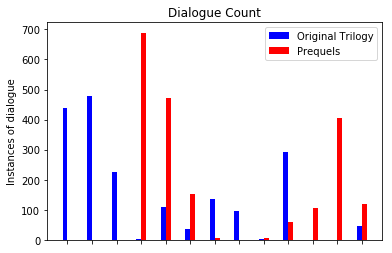

In [39]:
fig, ax = plt.subplots()

width = 0.2
index = np.arange(len(Character_List))

labels2 = seen_all_JJB.columns[:10].append(seen_all_JJB.columns[11:]) #exclude R2

OT = ax.bar(index - .5*width, OT_Dialogue_Count, width, color='blue')
prequels = ax.bar(index + .5*width, Prequels_Dialogue_Count, width, color='red')



ax.set_ylabel('Instances of dialogue')
ax.set_title('Dialogue Count')
ax.set_xticks(index)
ax.set_xticklabels([(x[12:]) for x in labels], rotation='vertical');


ax.legend((OT[0], prequels[0]), ('Original Trilogy', 'Prequels'));

And now again in plotly.

In [40]:
trace5 = go.Bar(
    name = 'Prequels',
    hoverinfo = 'text',
    y = [(x[12:]) for x in labels2],
    x = -1*Prequels_Dialogue_Count,
    orientation = 'h',
    text = [str(x) + ' lines of dialogue' for x in Prequels_Dialogue_Count],
    opacity=1,
    width=.55,
    
)

trace6 = go.Bar(
    name = 'base',
    hoverinfo = 'none',
    y = [(x[12:]) for x in labels2],
    x = Prequels_Dialogue_Count,
    orientation = 'h',
    opacity=0,
    width=.55,
    showlegend=False,
    
)

trace7 = go.Bar(
    name = 'Original Trilogy',
    hoverinfo = 'text',
    y = [(x[12:]) for x in labels2],
    x = OT_Dialogue_Count,
    orientation = 'h',
    text = [str(x) + ' lines of dialogue' for x in OT_Dialogue_Count],
    opacity=1,
    width=.55,
)

data2 = [trace5, trace6, trace7]
layout = go.Layout(
    barmode='stack',
    yaxis=dict(autorange='reversed', tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor ='rgb(0,0,0)', linewidth=0 ), 
    title='<b>Whose Line is it Anyway?</b> <br> Instances of Dialogue per Character',
    titlefont =dict(color='rgb(255,255,255)', 
                   size =21,
                   family = 'open sans'),          
    plot_bgcolor='rgba(10, 0, 0, 1)',
    paper_bgcolor ='rgba(10, 0, 0, 1)',
    margin=dict(l=160), 
    annotations=[ ],
    legend=dict(orientation = 'h', font=dict(color='rgb(255,255,255)'), traceorder = 'normal'),
    xaxis=dict(tickvals = [-600,-400,-200,0,200,400],tickmode="array", ticktext = [600,400,200,0,200,400], tickfont=dict(family='open sans', size=14,color='rgb(255,255,255)'), linecolor ='rgb(0,0,0)', linewidth=0),
)

fig = go.Figure(data=data2, layout=layout)
iplot(fig)

This graph augments the previous plotly figures that looked at popularity between fans and non-fans. We can see that Jar Jar does not even speak that often relative to some of the other characters in the survey and yet he is strongly disliked by fans, even more so than the evil Emperor Palpatine [not sure if that one counts as a spoiler or not].

Although it is unclear whether non-fans like the prequels more because they like the characters or vice versa, it is likely an endogenous effect.


## PART H
### Auxiliary Natural Language Processing

Now, since, we already have all this data, I thought it might be interesting to process the scripts with the natural language processing toolkit. I'm not looking for anything in particular so much as I am just curious what might be found!

In [41]:
n_top_Prequels = 11 #some initial cleaning to make keeping track of the data easier
n_top_OT = 9
aux_top_chars_OT = Top_Characters_OT[:n_top_OT]
aux_top_chars_Prequels = Top_Characters_Prequels[:n_top_Prequels]
top_char_diags_OT = [" " for x in aux_top_chars_OT]
top_char_diags_Prequels = [" " for x in aux_top_chars_Prequels]

for i in range(len(Char_OT_Raw)): #combine all the strings together for most talkative characters in Original Trilogy 
    for j in range(n_top_OT):
        if Char_OT_Raw[i] == aux_top_chars_OT[j]:
            top_char_diags_OT[j] += Dialogues_OT[i] + " "
            
for i in range(len(Char_Prequels_Raw)): #same but for prequels
    for j in range(n_top_Prequels):
        if Char_Prequels_Raw[i] == aux_top_chars_Prequels[j]:
            top_char_diags_Prequels[j] += Dialogues_Prequels[i] + " "

In [42]:
stop = set(stopwords.words('english')) #will remove stop words from the script
exclude = set(string.punctuation)  #removes the punctuation marks
lemma = WordNetLemmatizer() #converts words to their stems i.e. women to woman and lying to lie

def clean(doc): #function that cleans the text corpus
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [43]:
#charcter in top_char_diags_OT:
dialogues_OT_clean = [clean(doc) for doc in top_char_diags_OT[:n_top_OT]] # run that function on OT top characters' dialogue

for i in range(n_top_OT): #generate tokens and each speaker's common bigrams
    tokens = nltk.word_tokenize(dialogues_OT_clean[i])
    text = nltk.Text(tokens)
    print(aux_top_chars_OT[i], '^', text.collocations())


uncle owen; dagobah system; garbage masher; ive got; detention level;
masher detention; captain solo; shut garbage; take care; aunt beru;
tow cable; look like; ben kenobi; change mind; full throttle; obiwan
kenobi; old ben; dark side; luke skywalker; little droid
LUKE ^ None
deflector shield; tractor beam; dont worry; old man; look like; ive
got; take care; boba fett; deck officer; pretty good; make jump; gas
mine; dont know; beam commission; boarded sometimes; angle deflector;
millennium falcon; keep distance; stay sharp; wheres leia
HAN ^ None
master luke; princess leia; come back; jabba hutt; form communication;
captain solo; fluent six; million form; six million; terribly sorry;
general solo; thank goodness; humancyborg relation; obiwan kenobi;
tractor beam; dont know; asteroid field; mean intrude; restraining
bolt; seethreepio humancyborg
THREEPIO ^ None
obiwan kenobi; dont know; energy shield; battle station; explanation
ease; asteroid field; ease escape; imperial senate; much lo

In [44]:
#get bigrams for the prequels
dialogues_Prequels_clean = [clean(doc) for doc in top_char_diags_Prequels]
for i in range(n_top_Prequels):
    tokens = nltk.word_tokenize(dialogues_Prequels_clean[i])
    text = nltk.Text(tokens)
    print(aux_top_chars_Prequels[i], '^', text.collocations())

dark side; outer rim; jar jar; wont let; dont know; coming around;
general grievous; end war; dont think; yes master; master windu; jedi
order; cooling unit; padawan learner; race tomorrow; sorry mlady;
brought peace; ray shield; vulture droids; dead ahead
ANAKIN ^ None
master yoda; eight plus; count dooku; much learn; bad feeling; may
force; command ship; bounty hunter; cato nemoidia; save energy; toxic
dart; chancellor palpatine; sith lord; old friend; jar jar; bring
balance; head toward; trade federation; weve got; jango fett
OBI-WAN ^ None
little boy; jar jar; apprentice legislator; ryoo pooja; chancellor
valorum; commerce guild; lake country; throw weapon; truly deeply;
trade federation; security measure; wouldnt like; count dooku; island
used; dont know; every day; whats bothering; let give; stop loving;
would wise
PADMÉ ^ None
jar jar; ambassador supreme; ever built; jar binks; credit fine;
physical self; supreme chancellor; weve got; planet core; trade
federation; use power; ei

If you have seen the Star Wars films before you may agree that these are pretty accurate characterizations of what the characters often say. Many of these are the names of other characters, but others represent idiosyncratic expressions. Even if it is just two words, they capture moments in the movies, like Palpatine's tempting Anakin to join the dark side in order to save Padme or Obi-Wan's then telling Luke about how his father was seduced to the dark side. This was a fun way to end the assignment that just begins to explore the possibilities available to find patterns in the Star Wars scripts.
  

# Conclusion

In this project I sought to explore the possible effects of bandwagoning within the Star Wars community that has caused many fans to perhaps unfairly deride the prequels. While it is impossible to know for sure the degree to which a bandwagon effect is present, the data do seem to suggest that there is increased polarization towards the trilogies in fans, probably as a result of taking cues from other fans. Certainly the argument for it is more strengthened by the analysis contained here than weakened. There is an association between considering oneself a fan of Star Wars and both disliking the prequels and Jar Jar Binks. Therefore, I think there is a solid case for individuals' self-identifying as fans leading to their wanting to adopt canon views, but such causality cannot be concluded here.

However, this is just one of many possible explanations. While the data supported everything I had initially thought of the community when I first was considering this project, this may just be another psychological effect: the confirmation bias. I tried to keep any conclusions drawn throughout the scope of this notebook limited and qualified, rather presenting the data, code, and figures instead. I hope the reader draws their own conclusions, even if they are opposed to mine. 



<img src="NYUBCpng-01.png">